In [1]:
# coding: utf-8
import os

import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from mydatools.plot import plot_multiclass_feature_dist
from mydatools.features_generate import mean_encoding

% matplotlib inline

## Config

In [2]:
trn_path = './data/input/application_train.csv'
tst_path = './data/input/application_test.csv'
id_col = 'SK_ID_CURR'
label_col = 'TARGET'

submission_path = './data/output/submission/EDA.csv'
output_id_col = id_col
output_label_col = label_col

## Load Data

In [3]:
trn_df = pd.read_csv(trn_path)
trn_df['ds_type'] = 'trn'
trn_df[label_col] = trn_df[label_col].astype('int')

tst_df = pd.read_csv(tst_path)
tst_df['ds_type'] = 'tst'

full_df = pd.concat([trn_df, tst_df])

del(trn_df)
del(tst_df)

full_df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,ds_type
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341,trn
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040,trn
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN,trn
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN,trn
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN,trn


In [4]:
# dataset type
is_trn = full_df['ds_type'] == 'trn'
is_tst = full_df['ds_type'] == 'tst'

In [5]:
full_df.shape

(356255, 123)

**label非常不平衡，大约10: 1**

In [6]:
full_df[label_col].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

## Features

In [7]:
feature_columns = []

def add_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

### application_train/test

**numerical_features**

In [8]:
numerical_features = full_df.dtypes[full_df.dtypes != 'object'].index.tolist()
numerical_features = [c for c in numerical_features if c not in [id_col, label_col, 'ds_type']]
add_features(numerical_features)

In [9]:
full_df[numerical_features].describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,...,356255.000000,356255.000000,356255.000000,185200.000000,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
mean,27425.560657,5.877674e+05,5.280200e+05,1.701161e+05,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,...,0.229661,0.015649,0.051371,0.103193,0.977889,0.977903,0.977239,0.752283,0.755548,0.759452
std,14732.808190,3.986237e+05,3.660650e+05,2.235068e+05,0.104250,0.079736,0.855949,0.786915,0.191374,1.865338,...,0.420616,0.124113,0.220753,0.108041,0.057929,0.058562,0.063165,0.113267,0.112057,0.110112
min,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16731.000000,2.700000e+05,2.340000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.041500,0.976700,0.976700,0.976700,0.687200,0.691400,0.699400
50%,25078.500000,5.002110e+05,4.500000e+05,1.530000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.069000,0.981600,0.981600,0.981600,0.755200,0.758500,0.764800
75%,34960.500000,7.975575e+05,6.750000e+05,2.025000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.128700,0.986600,0.986600,0.986600,0.823200,0.825600,0.823600
max,258025.500000,4.050000e+06,4.050000e+06,1.170000e+08,9.000000,4.000000,27.000000,261.000000,8.000000,25.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**categorical_features**

In [10]:
categorical_features = full_df.dtypes[full_df.dtypes == 'object'].index.tolist()
full_df[categorical_features].nunique()

CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
ds_type                        2
dtype: int64

In [11]:
categorical_features = categorical_features[:-1] # 为了去掉ds_type
# 去掉分类数太多
# categorical_features = full_df[categorical_features].columns[full_df[categorical_features].nunique() <= 10]

# get dummies
temp_df = full_df[categorical_features].copy()
temp_df = pd.get_dummies(temp_df, prefix_sep=':')
for c in temp_df.columns:
    full_df[c] = temp_df[c]

# add features
add_features(temp_df.columns.tolist())

增加分类变量的mean-encoding，因为训练集和测试集完全随机分割，随意直接使用最普通的mean-encoding应该也不太会出现过拟合

In [12]:
for c in categorical_features:
    full_df, new_feat = mean_encoding(full_df, c, label_col, is_tst, return_feature_name=True)
    add_features(new_feat)

**各收入项占贷款比例**

In [13]:
full_df['AMT_INCOME_TOTAL_device_AMT_GOODS_PRICE'] = full_df['AMT_INCOME_TOTAL'] / full_df['AMT_GOODS_PRICE']
full_df['AMT_CREDIT_device_AMT_GOODS_PRICE'] = full_df['AMT_CREDIT'] / full_df['AMT_GOODS_PRICE']
full_df['AMT_ANNUITY_device_AMT_GOODS_PRICE'] = full_df['AMT_ANNUITY'] / full_df['AMT_GOODS_PRICE']
full_df['AMT_INCOME_TOTAL_device_AMT_ANNUITY'] = full_df['AMT_INCOME_TOTAL'] / full_df['AMT_ANNUITY']
full_df['AMT_CREDIT_device_AMT_ANNUITY'] = full_df['AMT_CREDIT'] / full_df['AMT_ANNUITY']

new_features = [
    'AMT_INCOME_TOTAL_device_AMT_GOODS_PRICE',
    'AMT_CREDIT_device_AMT_GOODS_PRICE',
    'AMT_ANNUITY_device_AMT_GOODS_PRICE',
    'AMT_INCOME_TOTAL_device_AMT_ANNUITY',
    'AMT_CREDIT_device_AMT_ANNUITY',
]
add_features(new_features)

In [14]:
full_df[new_features].describe()

,AMT_INCOME_TOTAL_device_AMT_GOODS_PRICE,AMT_CREDIT_device_AMT_GOODS_PRICE,AMT_ANNUITY_device_AMT_GOODS_PRICE,AMT_INCOME_TOTAL_device_AMT_ANNUITY,AMT_CREDIT_device_AMT_ANNUITY
count,355977.000000,355977.000000,355941.000000,356219.000000,356219.000000
mean,0.459271,1.124213,0.061961,7.335334,21.005276
std,0.581067,0.124172,0.025477,8.944140,7.783368
min,0.011801,0.150000,0.007500,0.493897,8.036674
25%,0.225000,1.000000,0.043245,4.363841,14.910747
50%,0.350000,1.118800,0.054095,6.128134,20.000000
75%,0.562500,1.198000,0.075920,8.699435,26.260412
max,257.425743,6.000000,0.300000,4466.586497,45.305079


**DAYS_XX**

DAYS_EMPLOYED看起来被填充过缺失值365243，把它恢复到na

In [15]:
full_df[full_df['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

In [16]:
full_df.loc[full_df['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan

然后增加DAYS_XX相关特征除以DAYS_BIRTH

In [17]:
full_df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
count,356255.000000,291607.000000,356255.000000,356255.000000
mean,-16041.248841,-2396.698937,-4983.593527,-3002.071163
std,4358.803980,2334.479967,3526.968986,1517.901735
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000
25%,-19676.000000,-3200.000000,-7477.000000,-4318.000000
50%,-15755.000000,-1663.000000,-4502.000000,-3252.000000
75%,-12425.000000,-780.000000,-1995.000000,-1717.000000
max,-7338.000000,0.000000,0.000000,0.000000


In [18]:
full_df['DAYS_EMPLOYED_device_DAYS_BIRTH'] = full_df['DAYS_EMPLOYED'] / full_df['DAYS_BIRTH']
full_df['DAYS_REGISTRATION_device_DAYS_BIRTH'] = full_df['DAYS_REGISTRATION'] / full_df['DAYS_BIRTH']
full_df['DAYS_ID_PUBLISH_device_DAYS_BIRTH'] = full_df['DAYS_ID_PUBLISH'] / full_df['DAYS_BIRTH']

new_features = [
    'DAYS_EMPLOYED_device_DAYS_BIRTH',
    'DAYS_REGISTRATION_device_DAYS_BIRTH',
    'DAYS_ID_PUBLISH_device_DAYS_BIRTH',
]
add_features(new_features)

In [19]:
full_df[new_features].describe()

,DAYS_EMPLOYED_device_DAYS_BIRTH,DAYS_REGISTRATION_device_DAYS_BIRTH,DAYS_ID_PUBLISH_device_DAYS_BIRTH
count,291607.000000,356255.000000,356255.000000
mean,0.157798,0.315666,0.194152
std,0.133450,0.214622,0.101872
min,-0.000000,-0.000000,-0.000000
25%,0.056954,0.130800,0.116953
50%,0.120075,0.301543,0.191962
75%,0.220598,0.470616,0.280646
max,0.728811,1.000004,0.469001


**EXT_SOURCE**

EXT_SOURCE的三个指标重要程度都很高，看看能不能基于这几个指标做扩展

In [20]:
feats = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

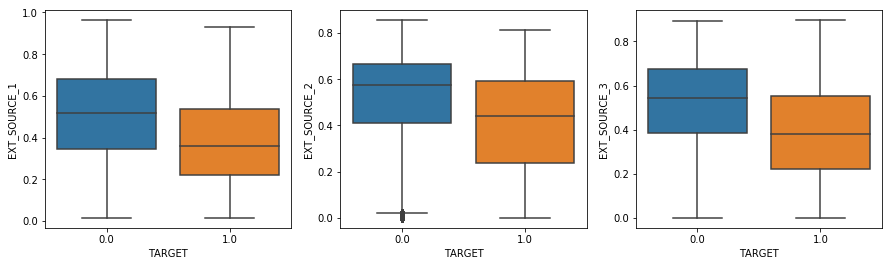

In [21]:
# 看起来label=1的三个特征都偏小
plt.figure(figsize=(15,4))
for i in range(len(feats)):
    plt.subplot(1,len(feats),i+1)
    sns.boxplot(x='TARGET', y='EXT_SOURCE_%d'%(i+1), data=full_df)

In [22]:
# 它们之间没有什么相关性
full_df[feats+['TARGET']].corr()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_1,1.000000,0.212987,0.181390,-0.155317
EXT_SOURCE_2,0.212987,1.000000,0.108480,-0.160472
EXT_SOURCE_3,0.181390,0.108480,1.000000,-0.178919
TARGET,-0.155317,-0.160472,-0.178919,1.000000


In [23]:
# 空值很多
full_df[feats].isnull().sum()

EXT_SOURCE_1    193910
EXT_SOURCE_2       668
EXT_SOURCE_3     69633
dtype: int64

In [24]:
full_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,0.083037,0.262949,0.139376,1.0
1,0.311267,0.622246,NaN,0.0
2,NaN,0.555912,0.729567,0.0
3,NaN,0.650442,NaN,0.0
4,NaN,0.322738,NaN,0.0
5,NaN,0.354225,0.621226,0.0
6,0.774761,0.724000,0.492060,0.0
7,NaN,0.714279,0.540654,0.0
8,0.587334,0.205747,0.751724,0.0
9,NaN,0.746644,NaN,0.0


In [25]:
# # 把是否为空值加入特征
# for c in feats:
#     full_df['isnull_' + c] = full_df[c].isnull().astype('int')
#     add_features('isnull_' + c)

### add extra data

In [26]:
def summary_extra_data(df, suffix):
    # 分类特征get_dummies
    df = pd.get_dummies(df, columns=df.columns[df.dtypes == 'object'].tolist())
    df = df.fillna(0)

    # 求平均
    df = pd.concat([
        df.groupby('SK_ID_CURR').mean(),
        df.groupby('SK_ID_CURR').size().rename('cnt'),
    ], axis=1)

    # 给特征加上前缀
    df.columns = [suffix+f for f in df.columns.tolist()]

    return df

In [27]:
# bureau = pd.read_csv('./data/input/bureau.csv')
# test_df = bureau.iloc[:100, :5]
# test_df.head()

# summary_extra_data(test_df, 'test')

**bureau.csv**

In [28]:
bureau = pd.read_csv('./data/input/bureau.csv')
bureau = bureau.drop('SK_ID_BUREAU', axis=1)

bureau = summary_extra_data(bureau, 'bureau_')

full_df = full_df.join(bureau, on='SK_ID_CURR')
add_features(bureau.columns.tolist())

**previous_application.csv**

In [29]:
prevapp = pd.read_csv('./data/input/previous_application.csv')
prevapp = prevapp.drop('SK_ID_PREV', axis=1)

prevapp = summary_extra_data(prevapp, 'prevapp_')

full_df = full_df.join(prevapp, on='SK_ID_CURR')
add_features(prevapp.columns.tolist())

**POS_CASH_balance.csv**

In [30]:
pcblc = pd.read_csv('./data/input/POS_CASH_balance.csv')
pcblc = pcblc.drop(['SK_ID_PREV', 'MONTHS_BALANCE'], axis=1)

pcblc = summary_extra_data(pcblc, 'pcblc_')

full_df = full_df.join(pcblc, on='SK_ID_CURR')
add_features(pcblc.columns.tolist())

**credit_card_balance.csv**

In [31]:
ccblc = pd.read_csv('./data/input/credit_card_balance.csv')
ccblc = ccblc.drop(['SK_ID_PREV', 'MONTHS_BALANCE'], axis=1)

ccblc = summary_extra_data(ccblc, 'ccblc_')

full_df = full_df.join(ccblc, on='SK_ID_CURR')
add_features(ccblc.columns.tolist())

**installments_payments.csv**

In [32]:
installpay = pd.read_csv('./data/input/installments_payments.csv')
installpay = installpay.drop(['SK_ID_PREV'], axis=1)

installpay = summary_extra_data(installpay, 'installpay_')

full_df = full_df.join(installpay, on='SK_ID_CURR')
add_features(installpay.columns.tolist())

In [33]:
len(feature_columns)

515

## LightGBM

In [34]:
trn_df = full_df[is_trn]
tst_df = full_df[is_tst]

X = trn_df[feature_columns]
y = trn_df[label_col]
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.20, random_state=20180521)

X_tst = tst_df[feature_columns]

d_trn = lgb.Dataset(X_trn.values, y_trn)
d_val = lgb.Dataset(X_val.values, y_val)

In [35]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 4,
    'num_leaves': 12,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'is_unbalance': True,
    'seed': 0,
    'reg_alpha': 0.1,
}
bst = lgb.train(params, d_trn, 500, valid_sets=[d_trn, d_val], early_stopping_rounds=20)

[1]	training's auc: 0.701725	valid_1's auc: 0.703732
Training until validation scores don't improve for 20 rounds.
[2]	training's auc: 0.708896	valid_1's auc: 0.711912
[3]	training's auc: 0.70991	valid_1's auc: 0.713507
[4]	training's auc: 0.718559	valid_1's auc: 0.721248
[5]	training's auc: 0.719522	valid_1's auc: 0.722401
[6]	training's auc: 0.721353	valid_1's auc: 0.72534
[7]	training's auc: 0.722852	valid_1's auc: 0.727185
[8]	training's auc: 0.729711	valid_1's auc: 0.733709
[9]	training's auc: 0.729264	valid_1's auc: 0.73316
[10]	training's auc: 0.730401	valid_1's auc: 0.734177
[11]	training's auc: 0.731883	valid_1's auc: 0.735592
[12]	training's auc: 0.731761	valid_1's auc: 0.73564
[13]	training's auc: 0.732709	valid_1's auc: 0.73663
[14]	training's auc: 0.733376	valid_1's auc: 0.737399
[15]	training's auc: 0.73396	valid_1's auc: 0.737925
[16]	training's auc: 0.734446	valid_1's auc: 0.738467
[17]	training's auc: 0.735474	valid_1's auc: 0.739326
[18]	training's auc: 0.735689	valid

[153]	training's auc: 0.784589	valid_1's auc: 0.778104
[154]	training's auc: 0.78474	valid_1's auc: 0.778144
[155]	training's auc: 0.784823	valid_1's auc: 0.778207
[156]	training's auc: 0.784961	valid_1's auc: 0.778264
[157]	training's auc: 0.785087	valid_1's auc: 0.778275
[158]	training's auc: 0.78519	valid_1's auc: 0.77835
[159]	training's auc: 0.785307	valid_1's auc: 0.778358
[160]	training's auc: 0.785453	valid_1's auc: 0.778354
[161]	training's auc: 0.785633	valid_1's auc: 0.778493
[162]	training's auc: 0.785764	valid_1's auc: 0.778561
[163]	training's auc: 0.785937	valid_1's auc: 0.778658
[164]	training's auc: 0.786106	valid_1's auc: 0.778763
[165]	training's auc: 0.786246	valid_1's auc: 0.778833
[166]	training's auc: 0.786332	valid_1's auc: 0.778803
[167]	training's auc: 0.786449	valid_1's auc: 0.778827
[168]	training's auc: 0.78655	valid_1's auc: 0.778805
[169]	training's auc: 0.786684	valid_1's auc: 0.778871
[170]	training's auc: 0.786849	valid_1's auc: 0.778926
[171]	training

[304]	training's auc: 0.800963	valid_1's auc: 0.783948
[305]	training's auc: 0.801122	valid_1's auc: 0.784024
[306]	training's auc: 0.80121	valid_1's auc: 0.784065
[307]	training's auc: 0.801272	valid_1's auc: 0.784084
[308]	training's auc: 0.801409	valid_1's auc: 0.784146
[309]	training's auc: 0.801493	valid_1's auc: 0.784162
[310]	training's auc: 0.801553	valid_1's auc: 0.784164
[311]	training's auc: 0.80165	valid_1's auc: 0.784159
[312]	training's auc: 0.801743	valid_1's auc: 0.784168
[313]	training's auc: 0.801863	valid_1's auc: 0.784261
[314]	training's auc: 0.801933	valid_1's auc: 0.784274
[315]	training's auc: 0.801986	valid_1's auc: 0.784292
[316]	training's auc: 0.802083	valid_1's auc: 0.784341
[317]	training's auc: 0.802162	valid_1's auc: 0.784391
[318]	training's auc: 0.802235	valid_1's auc: 0.784468
[319]	training's auc: 0.802277	valid_1's auc: 0.784439
[320]	training's auc: 0.80233	valid_1's auc: 0.784458
[321]	training's auc: 0.802426	valid_1's auc: 0.784533
[322]	trainin

[455]	training's auc: 0.813296	valid_1's auc: 0.786262
[456]	training's auc: 0.813355	valid_1's auc: 0.78624
[457]	training's auc: 0.813421	valid_1's auc: 0.786236
[458]	training's auc: 0.813448	valid_1's auc: 0.786249
[459]	training's auc: 0.813486	valid_1's auc: 0.786263
[460]	training's auc: 0.813538	valid_1's auc: 0.786275
[461]	training's auc: 0.813601	valid_1's auc: 0.78631
[462]	training's auc: 0.813622	valid_1's auc: 0.786339
[463]	training's auc: 0.813726	valid_1's auc: 0.786348
[464]	training's auc: 0.813796	valid_1's auc: 0.786328
[465]	training's auc: 0.81387	valid_1's auc: 0.786379
[466]	training's auc: 0.813954	valid_1's auc: 0.786445
[467]	training's auc: 0.814062	valid_1's auc: 0.786477
[468]	training's auc: 0.814118	valid_1's auc: 0.786458
[469]	training's auc: 0.814179	valid_1's auc: 0.786419
[470]	training's auc: 0.814279	valid_1's auc: 0.786385
[471]	training's auc: 0.814329	valid_1's auc: 0.786405
[472]	training's auc: 0.814354	valid_1's auc: 0.786428
[473]	trainin

In [36]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
EXT_SOURCE_3,205
EXT_SOURCE_1,202
EXT_SOURCE_2,191
AMT_CREDIT_device_AMT_ANNUITY,164
DAYS_BIRTH,103
pcblc_CNT_INSTALMENT_FUTURE,88
DAYS_EMPLOYED,86
AMT_ANNUITY,78
AMT_CREDIT_device_AMT_GOODS_PRICE,69
installpay_AMT_PAYMENT,65


## predict

In [37]:
res_df = pd.DataFrame(bst.predict(X_tst), columns=[output_label_col])
res_df[output_id_col] = tst_df[output_id_col].values
res_df[[output_id_col, output_label_col]].to_csv(submission_path, index=False)